In [1]:
%matplotlib inline
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [165]:
import string

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nengo
import pandas as pd
import seaborn as sns

from cogsci17_decide.networks import IA, LCA

In [154]:
sns.set('poster', 'darkgrid', font_scale=1.5)
    
def plot_optimum_line(ax, y):
    ax.axhline(y=y, lw=6, c=(.5, .5, .5))

# Load data and do some preprocessing

In [155]:
df = pd.DataFrame({k: np.squeeze(v) for k, v in np.load('../data/decision.npz').iteritems()})

In [156]:
dfd = df.query('decided == True')

# LCA

In [157]:
dt = 0.001

with nengo.Network(seed=1) as model:
    wta = LCA(3, 200, dt=dt)
    stimulus = nengo.Node([0.8, 0.7, 0.6])
    nengo.Connection(stimulus, wta.input, synapse=None)
    
    p_stimulus = nengo.Probe(stimulus, synapse=None)
    p_output = nengo.Probe(wta.output, synapse=0.01)

In [158]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(1.)

In [177]:
seq_pal = 'Reds'
n_colors = len(df['target_sep'].unique())

class MultiSeqHandler(object):
    def __init__(self, color_palettes, n_colors):
        self.color_palettes = [sns.color_palette(cp, n_colors=n_colors) for cp in color_palettes]
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        r = min(h, w / len(self.color_palettes)) / 2.
        
        for i, cp in enumerate(self.color_palettes):
            handlebox.add_artist(mpatches.Circle((x0 + 2 * r * i + r, y0 + r), 0.9 * r, fc=cp[orig_handle], ec='none'))

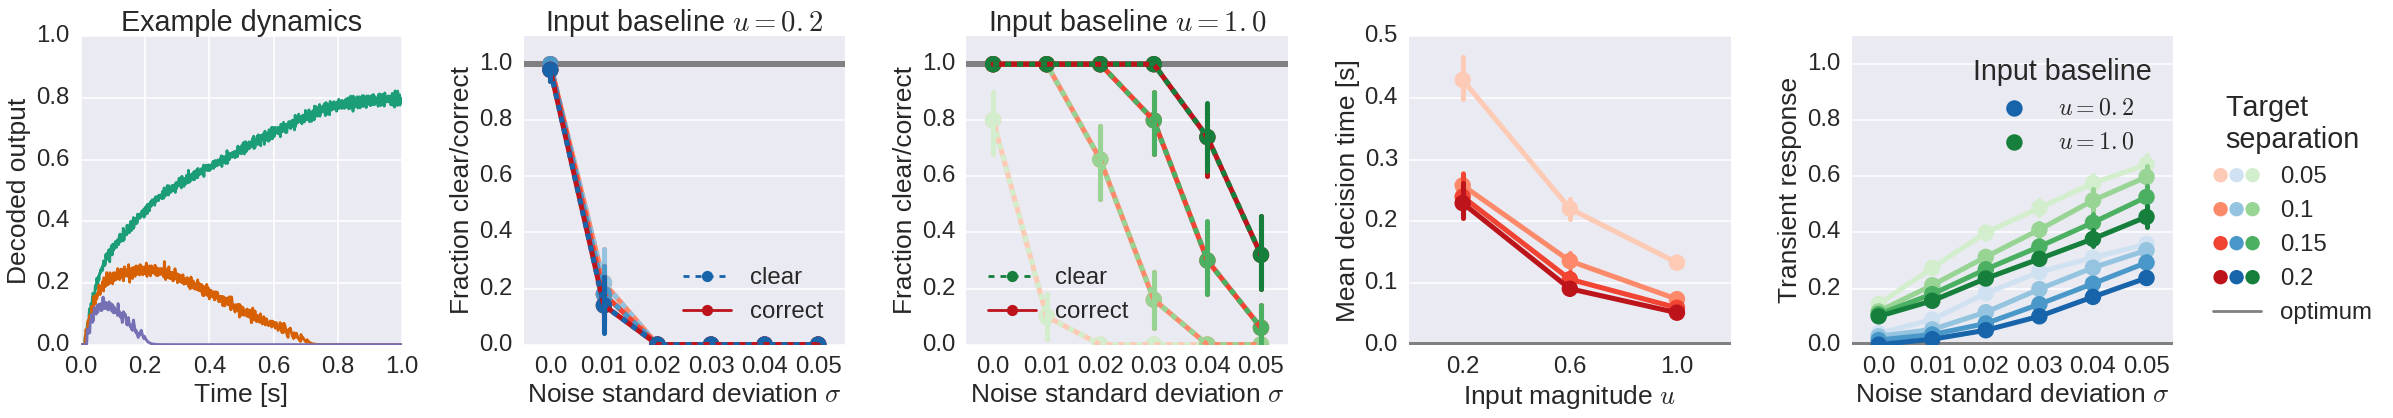

In [190]:
fig = plt.figure(figsize=(33.64, 6.47))
with sns.color_palette('Dark2'):
    ax1 = fig.add_subplot(1, 5, 1)
ax2 = fig.add_subplot(1, 5, 2)
ax3 = fig.add_subplot(1, 5, 3, sharey=ax2)
ax4 = fig.add_subplot(1, 5, 4)
ax5 = fig.add_subplot(1, 5, 5)

ax1.plot(sim.trange(), sim.data[p_output])
ax1.set_title("Example dynamics")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Decoded output")
ax1.locator_params(axis='x', nbins=5)
ax1.locator_params(axis='y', nbins=5)

for ax, baseline, pal in zip((ax2, ax3), (0.2, 1.0), ('Blues', 'Greens')):
    plot_optimum_line(ax, 1.)
    data = df.query('network == "LCA" and baseline == {}'.format(baseline))
    sns.pointplot('noise', 'correct', 'target_sep', data=data, palette=seq_pal, ax=ax)
    sns.pointplot('noise', 'decided', 'target_sep', data=data, palette=pal, ax=ax, linestyles='--')
    
    ax.set_ylim(bottom=0., top=1.1)
    
    ax.set_title("Input baseline $u={}$".format(baseline))
    ax.set_xlabel(r"Noise standard deviation $\sigma$")
    ax.set_ylabel("Fraction clear/correct")

    h1 = mlines.Line2D([], [], color=sns.color_palette(pal, n_colors=n_colors)[-1], label='clear', ls='--', marker='o')
    h2 = mlines.Line2D([], [], color=sns.color_palette(seq_pal, n_colors=n_colors)[-1], label='correct', marker='o')
    ax.legend(handles=[h1, h2], loc='best')
    
plot_optimum_line(ax4, 0)
sns.pointplot('baseline', 't', 'target_sep', data=dfd.query('network == "LCA"'), palette=seq_pal, ax=ax4)
ax4.set_ylim(bottom=0)
ax4.set_xlabel("Input magnitude $u$")
ylabel = ax4.set_ylabel("Mean decision time [s]")
ax4.legend().remove()

sns.pointplot('noise', 'runnerup_highest_err', 'target_sep',
              data=df.query('network == "LCA" and baseline == .2'),
              palette='Blues', ax=ax5)
sns.pointplot('noise', 'runnerup_highest_err', 'target_sep',
              data=df.query('network == "LCA" and baseline == 1.'),
              palette='Greens', ax=ax5)
plot_optimum_line(ax5, 0)
ax5.set_ylim(0, 1.1)
ax5.set_xlabel(r"Noise standard deviation $\sigma$")
ax5.set_ylabel("Transient response")
handles = (handle for handle, label in zip(*ax5.get_legend_handles_labels()) if label == '0.2')
ax5.legend(handles, ("$u=0.2$", "$u=1.0$"), title="Input baseline")

optimum_handle = mlines.Line2D([], [], color=(.5, .5, .5))
fig.legend(list(range(n_colors)) + [optimum_handle], sorted(df['target_sep'].unique()) + ["optimum"],
           loc='right', title="Target\nseparation",
           handler_map={int: MultiSeqHandler(('Reds', 'Blues', 'Greens'), n_colors)})

fig.tight_layout(rect=(0, 0, 0.92, 1))
fig.savefig('../doc/poster/lca.pdf', bbox_inches='tight', pad_inches=0.)

# IA

In [192]:
dt = 0.001

with nengo.Network(seed=1) as model:
    wta = IA(3, 200, dt=dt)
    stimulus = nengo.Node([0.8, 0.7, 0.6])
    nengo.Connection(stimulus, wta.input, synapse=None)
    
    p_stimulus = nengo.Probe(stimulus, synapse=None)
    p_state = nengo.Probe(wta.x.output, synapse=0.01)
    p_output = nengo.Probe(wta.output, synapse=0.01)

In [193]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(.4)

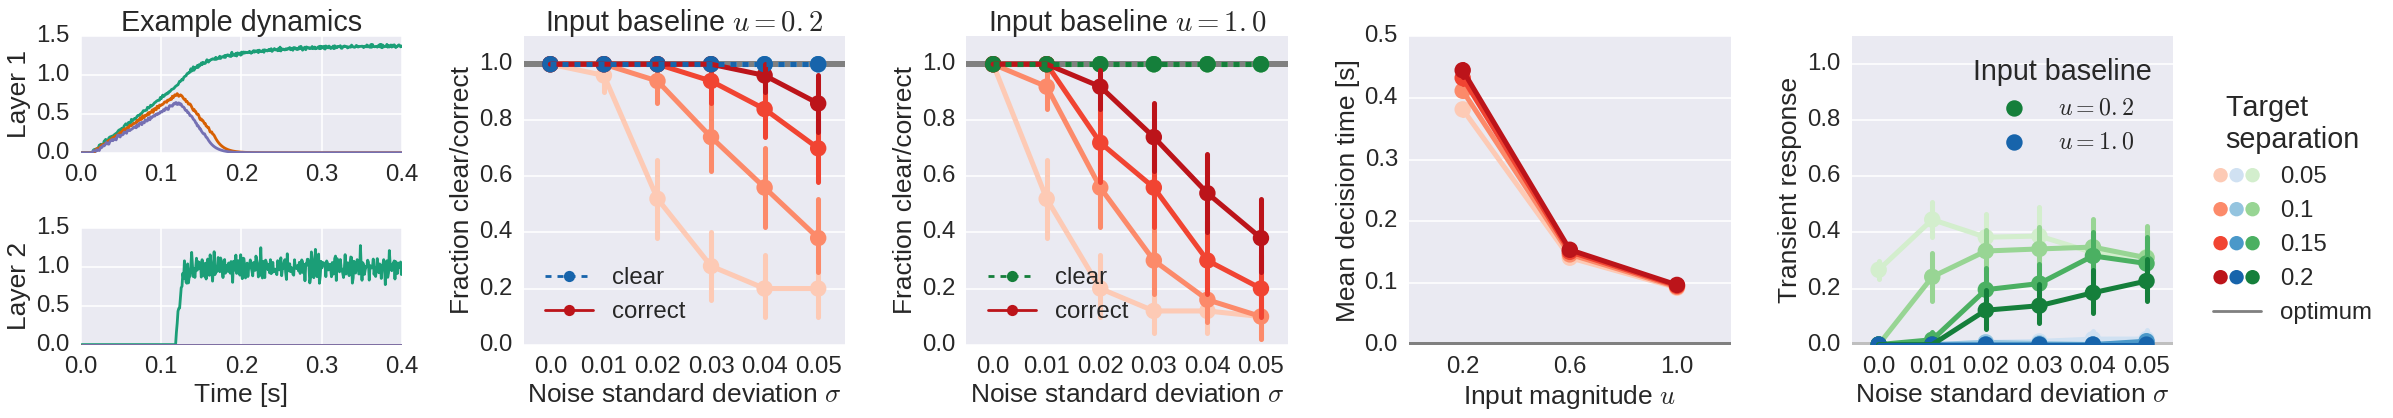

In [202]:
fig = plt.figure(figsize=(33.64, 6.47))
with sns.color_palette('Dark2'):
    ax1a = plt.subplot2grid((2, 5), (0, 0))
    ax1b = plt.subplot2grid((2, 5), (1, 0), sharex=ax1a, sharey=ax1a)
ax2 = plt.subplot2grid((2, 5), (0, 1), rowspan=2)
ax3 = plt.subplot2grid((2, 5), (0, 2), rowspan=2, sharey=ax2)
ax4 = plt.subplot2grid((2, 5), (0, 3), rowspan=2)
ax5 = plt.subplot2grid((2, 5), (0, 4), rowspan=2)

ax1a.plot(sim.trange(), sim.data[p_state])
ax1a.locator_params(axis='y', nbins=5)
ax1a.set_title("Example dynamics")
ax1a.set_ylabel("Layer 1")

ax1b.plot(sim.trange(), sim.data[p_output])
ax1b.locator_params(axis='y', nbins=5)
ax1b.locator_params(axis='x', nbins=5)
ax1b.set_xlim(0, .4)
ax1b.set_xlabel("Time [s]")
ax1b.set_ylabel("Layer 2")

for ax, baseline, scale, pal in zip((ax2, ax3), (0.2, 1.0), (1.0, 1.0), ('Blues', 'Greens')):
    plot_optimum_line(ax, 1.)
    data = df.query('network == "IA" and baseline == {} and scale == {} and not share_thresholding_intercepts'.format(
        baseline, scale))
    sns.pointplot('noise', 'correct', 'target_sep', data=data, palette=seq_pal, ax=ax)
    sns.pointplot('noise', 'decided', 'target_sep', data=data, palette=pal, ax=ax, linestyles='--')
    
    ax.set_ylim(bottom=0., top=1.1)
    
    ax.set_title("Input baseline $u={}$".format(baseline))
    ax.set_xlabel(r"Noise standard deviation $\sigma$")
    ax.set_ylabel("Fraction clear/correct")
    
    h1 = mlines.Line2D([], [], color=sns.color_palette(pal, n_colors=n_colors)[-1], label='clear', ls='--', marker='o')
    h2 = mlines.Line2D([], [], color=sns.color_palette(seq_pal, n_colors=n_colors)[-1], label='correct', marker='o')
    ax.legend(handles=[h1, h2], loc='best')
    
plot_optimum_line(ax4, 0)
sns.pointplot('baseline', 't', 'target_sep',
              data=dfd.query('network == "IA" and scale == 1. and not share_thresholding_intercepts'),
              palette=seq_pal, ax=ax4)
ax4.set_ylim(bottom=0)
ax4.set_xlabel("Input magnitude $u$")
ylabel = ax4.set_ylabel("Mean decision time [s]")
ax4.legend().remove()

sns.pointplot('noise', 'runnerup_highest_err', 'target_sep',
              data=df.query('network == "IA" and baseline == 1. and scale == 1. and not share_thresholding_intercepts'),
              palette='Greens', ax=ax5)
sns.pointplot('noise', 'runnerup_highest_err', 'target_sep',
              data=df.query('network == "IA" and baseline == .2 and scale == 1. and not share_thresholding_intercepts'),
              palette='Blues', ax=ax5)
ax5.axhline(y=0., lw=6, c=(0.75, 0.75, 0.75))
ax5.set_ylim(0, 1.1)
ax5.set_xlabel(r"Noise standard deviation $\sigma$")
ax5.set_ylabel("Transient response")
handles = (handle for handle, label in zip(*ax5.get_legend_handles_labels()) if label == '0.2')
ax5.legend(handles, ("$u=0.2$", "$u=1.0$"), title="Input baseline")

optimum_handle = mlines.Line2D([], [], color=(.5, .5, .5))
fig.legend(list(range(n_colors)) + [optimum_handle], sorted(df['target_sep'].unique()) + ["optimum"],
           loc='right', title="Target\nseparation",
           handler_map={int: MultiSeqHandler(('Reds', 'Blues', 'Greens'), n_colors)})

fig.tight_layout(rect=(0, 0, 0.92, 1))
fig.savefig('../doc/poster/ia.pdf', bbox_inches='tight', pad_inches=0.)